In [1]:
import os
import numpy as np
import mne

import torch as th
import torch.nn as nn

import librosa
import librosa.display
np.float = np.float64 # Fix librosa

import matplotlib.pyplot as plt
from IPython.display import Audio, display

In [2]:
GEN_ID = '01'
ROOT_PATH = 'preprocessing/data'

In [3]:
musics = np.load('ONR_MUSIC.npy', allow_pickle=True).item()

# Load Data

In [4]:
for SUB_ID in range(1, 22):
    if SUB_ID == 17:
        continue
    print(f'Loading SUB_ID: {SUB_ID}')
    data = mne.io.read_raw_fif(os.path.join(ROOT_PATH, f'ica_sub-{SUB_ID:02d}_task-genMusic{GEN_ID}_eeg.fif'))
    break
    
    # # Remove unknown events
    # events = mne.find_events(data, stim_channel='music')
    # event_filter = np.ones_like(events[:, 2], dtype=bool)
    # for idx, eid in enumerate(map(lambda x: f'{x[0]}-{x[1]}_{x[2]}.wav', events[:, 2].astype(str))):
    #     if eid not in musics:
    #         event_filter[idx] = False
    #         print(f'Remove event: {eid} @ {events[idx][0]/512} second(s).')
    # events = events[event_filter]
    # epochs = mne.Epochs(data, events, tmin=0, tmax=40, baseline=None)

Loading SUB_ID: 1
Opening raw data file preprocessing/data\ica_sub-01_task-genMusic01_eeg.fif...
    Range : 0 ... 379903 =      0.000 ...   741.998 secs
Ready.


In [5]:
data

<Raw | ica_sub-01_task-genMusic01_eeg.fif, 47 x 379904 (742.0 s), ~56 kB, data not loaded>

# Remove unknown events

In [6]:
events = mne.find_events(data, stim_channel='music')
music_lists = []
event_filter = np.ones_like(events[:, 2], dtype=bool)
for idx, eid in enumerate(map(lambda x: f'{x[0]}-{x[1]}_{x[2]}.wav', events[:, 2].astype(str))):
    if eid not in musics:
        event_filter[idx] = False
        print(f'Remove event: {eid} @ {events[idx][0]/512} second(s).')
    else:
        music_lists.append(eid)
events = events[event_filter]
epochs = mne.Epochs(data, events, picks='eeg', tmin=0, tmax=40, baseline=None)

11 events found
Event IDs: [281 282 283 452 821 822 823]
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


In [7]:
epochs.get_data().shape

Loading data for 11 events and 20481 original time points ...
0 bad epochs dropped


(11, 31, 20481)

In [8]:
raw_data = epochs.get_data()[:, :, :int(data.info['sfreq']*40)]
raw_data.shape

Loading data for 11 events and 20481 original time points ...


(11, 31, 20480)

# Configure

In [9]:
# mode = 'STFT'; lower_freq = None; y_transform = None
# mode = 'WAV'; lower_freq = False; y_transform = 'SCALE'
mode = 'WAV'; lower_freq = True ; y_transform = 'NORM'   # Ref:Paper

# Setup Input -> Output

## from EEG to STFT

In [10]:
if mode == 'STFT':
    raw_X = raw_data.reshape(len(events), 31, 32, -1)
    # (N:batch, H:hidden, L:length, loop) -> (loop, L:length, N:batch, H:hidden)
    raw_X = raw_X.transpose(3, 2, 0, 1)
    print('X:', raw_X.shape)

    raw_Y = np.asarray([musics[mid]['targets'] for mid in music_lists])
    raw_Y = raw_Y.transpose(1, 3, 0, 2)
    print('Y:', raw_Y.shape) # (y_ch, batch, t, freq)

## from EEG to WAV

In [11]:
if mode == 'WAV':
    mid = music_lists[0]
    target_sr = musics[mid]['rate-low']
    if lower_freq: # Reference from original paper, Down-sampling outputs to 100hz

        target_sr = 102.4  # Reampling to 102.4 hz for a same length of input
        def resample(x, orig_sr=musics[mid]['rate-low'], target_sr=target_sr):
            return librosa.resample(x, orig_sr=orig_sr, target_sr=target_sr)

        for mid in musics.keys():
            print(mid, ':', musics[mid]['data-low'].shape, '>>', end=' ')
            musics[mid]['data-low'] = resample(musics[mid]['data-low'])
            print(musics[mid]['data-low'].shape)
            musics[mid]['rate-low'] = target_sr

    # (N:batch, H:hidden, L:length, loop) -> (loop, L:length, N:batch, H:hidden)
    raw_X = raw_data.transpose(2, 0, 1)
    print('X:', raw_X.shape)

    raw_Y = np.asarray([musics[mid]['data-low'] for mid in music_lists])
    raw_Y = raw_Y.reshape(len(music_lists), -1, 2).transpose(1, 0, 2)
    print('Y:', raw_Y.shape) # (t, batch, wav)

9-7_1.wav : (40960,) >> (4096,)
7-5_1.wav : (40960,) >> (4096,)
7-5_3.wav : (40960,) >> (4096,)
8-2_3.wav : (40960,) >> (4096,)
8-7_2.wav : (40960,) >> (4096,)
2-8_1.wav : (40960,) >> (4096,)
8-2_2.wav : (40960,) >> (4096,)
4-5_3.wav : (40960,) >> (4096,)
4-8_2.wav : (40960,) >> (4096,)
4-5_1.wav : (40960,) >> (4096,)
5-4_3.wav : (40960,) >> (4096,)
4-5_2.wav : (40960,) >> (4096,)
2-8_3.wav : (40960,) >> (4096,)
5-9_1.wav : (40960,) >> (4096,)
2-8_2.wav : (40960,) >> (4096,)
7-5_2.wav : (40960,) >> (4096,)
8-2_1.wav : (40960,) >> (4096,)
X: (20480, 11, 31)
Y: (2048, 11, 2)


# Input/Output Preprocess

## Cuda

In [12]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

## Input

In [13]:
X = ((raw_X - raw_X.min())/(raw_X.max() - raw_X.min()))
X = th.Tensor(X).to(device)
if mode == 'WAV' and lower_freq:
    X = X.transpose(0, 1).reshape(11, 2048, 310).transpose(0, 1)
print('Input:', X.shape)

Input: torch.Size([2048, 11, 310])


## Output

### STFT

In [14]:
if mode == 'STFT':
    Y_real = ((np.abs(raw_Y) - np.abs(raw_Y).min())/(np.abs(raw_Y).max() - np.abs(raw_Y).min()))
    # Y_real = np.abs(raw_Y.real)
    Y_angle = np.angle(raw_Y)/np.pi
    Y = np.stack([Y_real, Y_angle], axis=3)
    Y = th.Tensor(Y).to(device)
    print('Output:', Y.shape)

### WAV

In [15]:
if mode == 'WAV':
    if y_transform == 'NORM':
        Y = (raw_Y - raw_Y.mean())/raw_Y.std()
    elif y_transform == 'SCALE':
        Y = raw_Y/np.abs(raw_Y).max()
    
    Y = th.Tensor(Y).to(device)
    print('Output:', Y.shape)

Output: torch.Size([2048, 11, 2])


# Models

## MLP

### STFT

In [15]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.linears = nn.Sequential(
            nn.Linear(input_size, 2 ** 13),
            nn.Tanh(),
            nn.BatchNorm1d(2 ** 13),
            nn.Linear(2 ** 13, 2 ** 11),
            nn.Tanh(),
            nn.BatchNorm1d(2 ** 11),
            nn.Linear(2 ** 11, 2 ** 9),
            nn.Tanh(),
            nn.BatchNorm1d(2 ** 9),
            nn.Linear(2 ** 9, output_size),
            nn.Tanh(),
        )
        
        self.linears_phase = nn.Sequential(
            nn.Linear(input_size, 2 ** 13),
            nn.Tanh(),
            nn.BatchNorm1d(2 ** 13),
            nn.Linear(2 ** 13, 2 ** 12),
            nn.Tanh(),
            nn.BatchNorm1d(2 ** 12),
            nn.Linear(2 ** 12, 2 ** 11),
            nn.Tanh(),
            nn.BatchNorm1d(2 ** 11),
            nn.Linear(2 ** 11, 2 ** 10),
            nn.Tanh(),
            nn.BatchNorm1d(2 ** 10),
            nn.Linear(2 ** 10, 2 ** 9),
            nn.Tanh(),
            nn.BatchNorm1d(2 ** 9),
            nn.Linear(2 ** 9, output_size),
            nn.Tanh(),
        )
        
    def forward(self, X):
        return th.stack([self.linears(X), self.linears_phase(X)], dim=1)


In [16]:
X.shape

torch.Size([640, 32, 11, 31])

In [17]:
X_t = X.transpose(1, 2).reshape(640, 11, -1)
X_t.shape, Y[0].shape

(torch.Size([640, 11, 992]), torch.Size([640, 11, 2, 33]))

In [18]:
net = MLPModel(
    input_size=X_t.shape[2],
    output_size=Y.shape[-1]
).to(device)

In [19]:
net(X_t[0]).shape

torch.Size([11, 2, 33])

### WAV

In [16]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.linears = nn.Sequential(
            nn.Linear(input_size, 2 ** 13),
            nn.Tanh(),
            nn.BatchNorm1d(2 ** 13),
            nn.Linear(2 ** 13, 2 ** 11),
            nn.Tanh(),
            nn.BatchNorm1d(2 ** 11),
            nn.Linear(2 ** 11, 2 ** 9),
            nn.Tanh(),
            nn.BatchNorm1d(2 ** 9),
            nn.Linear(2 ** 9, output_size),
            nn.Tanh(),
        )
        
    def forward(self, X):
        return self.linears(X)

In [17]:
X.shape

torch.Size([20480, 11, 31])

In [18]:
net = MLPModel(
    input_size=X.shape[-1],
    output_size=Y.shape[-1]
).to(device)

In [19]:
net(X[0]).shape

torch.Size([11, 2])

In [20]:
Y.shape

torch.Size([20480, 11, 2])

## biLSTM + MLP

## WAV

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, feature_size, num_layer, hidden_size, output_size):
        super().__init__()
        
        self.linears = nn.Sequential(
            nn.Linear(input_size, feature_size//4),
            nn.Sigmoid(),
            nn.Linear(feature_size//4, feature_size//2),
            nn.Sigmoid(),
            nn.Linear(feature_size//2, feature_size),
            nn.Sigmoid(),
        )
        
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=hidden_size,
            num_layers=num_layer,
            bidirectional=True
        )
        
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.Tanh(),
            nn.Linear(hidden_size//2, output_size),
        )
    
    def forward(self, X, state=None):
        out_1 = self.linears(X)
        state = None
        out_2 = []
        for inp in out_1:
            out, state = self.lstm(inp, state)
            out_2.append(out)
        out_2 = th.stack(out_2)
        
        out_3 = self.mlp(out_2)
        
        return out_3, state

In [17]:
if not lower_freq:
    net = LSTMModel(
        input_size=31,
        feature_size=256,
        num_layer=4,
        hidden_size=256,
        output_size=2,
    ).to(device)

if lower_freq:
    # 100 hz
    net = LSTMModel(
        input_size=310,
        feature_size=256,
        num_layer=4,
        hidden_size=256,
        output_size=2,
    ).to(device)

In [18]:
'Parameters:', sum([np.prod(p.shape) for p in net.parameters()])

('Parameters:', 6009282)

### Debug

In [ ]:
X[:512].shape

In [ ]:
out_1 = net.linears(X[:512])
out_1.shape

In [ ]:
out_2, states = net.lstm(out_1)
out_2.shape, states[0].shape, states[1].shape

In [ ]:
out_3 = net.mlp(out_2)
out_3.shape

In [ ]:
out, state = net(X[:512])
out.shape, state[0].shape, state[1].shape

In [ ]:
Y[:512].shape

## STFT

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, feature_size, n_channels, num_layer, hidden_size, output_size):
        super().__init__()
        
        self.linears = nn.Sequential(
            nn.Linear(input_size, feature_size//2),
            nn.Sigmoid(),
            nn.Linear(feature_size//2, feature_size),
            nn.Sigmoid(),
        )
        
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=hidden_size,
            num_layers=num_layer,
            bidirectional=True
        )
        
        self.max_pooling = nn.MaxPool2d(kernel_size=(n_channels, 1))
        
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.Tanh(),
            nn.Linear(hidden_size//2, output_size),
            nn.Tanh(),
        )
        
        self.mlp_phase = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.Tanh(),
            nn.Linear(hidden_size//2, output_size),
            nn.Tanh(),
        )
    
    def forward(self, X, state=None):
        out_1 = self.linears(X)
        state = None
        out_2 = []
        for inp in out_1:
            out, state = self.lstm(inp, state)
            out_2.append(out)
        out_2 = th.stack(out_2)
        
        out_3 = self.mlp(out_2)
        out_real = self.max_pooling(out_3).flatten(start_dim=2)
        
        out_4 = self.mlp_phase(out_2)
        out_phase = self.max_pooling(out_4).flatten(start_dim=2)
        
        return th.stack([out_real, out_phase], dim=2), state

In [17]:
net = LSTMModel(
    input_size=31,
    feature_size=128,
    n_channels=32,
    num_layer=3,
    hidden_size=250,
    output_size=33,
).to(device)

In [18]:
X_t = X.transpose(1, 2)
X_t.shape

torch.Size([640, 11, 32, 31])

### Debug

In [ ]:
X_t[:32].shape

In [ ]:
out_1 = net.linears(X_t[:32])
out_1.shape

In [ ]:
state = None
out_2 = []
for inp in out_1:
    out, state = net.lstm(inp, state)
    out_2.append(out)
out_2 = th.stack(out_2)
out_2.shape, state[0].shape, state[1].shape

In [ ]:
out_3 = net.mlp(out_2)
out_3.shape

In [ ]:
out_real = net.max_pooling(out_3).flatten(start_dim=2)
out_real.shape

In [ ]:
out_4 = net.mlp_phase(out_2)
out_phase = net.max_pooling(out_4).flatten(start_dim=2)
out_phase.shape

In [ ]:
out = th.stack([out_real, out_phase], dim=2)
out.shape

In [ ]:
Y[0, :32].shape

In [ ]:
out, state = net(X_t[:32])
out.shape, state[0].shape, state[1].shape

## GRU + MLP

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, num_layer = 2, hidden_size = 512, input_t=32, output_size=129):
        super().__init__()
        
        self.gru = nn.GRU(31, hidden_size, num_layer)
        
        self.linears = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.Tanh(),
            nn.Linear(hidden_size//2, output_size),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(input_t, 1)),
        )
        
        self.linears_phase = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.Tanh(),
            nn.Linear(hidden_size//2, output_size),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(input_t, 1)),
        )
    
    def forward(self, X, hn=None):
        out_lstm, hn = self.gru(X, hn)
        out_temp = out_lstm.transpose(0, 1)
        out_real = self.linears(out_temp).flatten(1)
        out_phase = self.linears_phase(out_temp).flatten(1)
        
        return th.stack([out_real, out_phase], dim=1), hn

In [ ]:
num_layer = 4
hidden_size = 512
input_t = 32
output_size = 129
baseline = GRUModel(
    num_layer=num_layer,
    hidden_size=hidden_size,
    input_t=input_t,
    output_size=output_size,
).to(device)

In [ ]:
out, hn = baseline(X[0])
out.shape, hn.shape
# (batch, real/phase, t, freq), (layer, batch, hidden/state)

In [ ]:
th.cuda.empty_cache()

## LSTM + CCN

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, feature_size, n_channels, num_layer, hidden_size, output_size):
        super().__init__()
        
        self.linears = nn.Sequential(
            nn.Linear(input_size, feature_size//2),
            nn.Sigmoid(),
            nn.Linear(feature_size//2, feature_size),
            nn.Sigmoid(),
        )
        
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=hidden_size,
            num_layers=num_layer,
            bidirectional=True
        )
        
        self.max_pooling = nn.MaxPool2d(kernel_size=(n_channels, 1))
        
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.Tanh(),
            nn.Linear(hidden_size//2, output_size),
            nn.Tanh(),
        )
        
        self.mlp_phase = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.Tanh(),
            nn.Linear(hidden_size//2, output_size),
            nn.Tanh(),
        )
    
    def forward(self, X, state=None):
        out_1 = self.linears(X)
        state = None
        out_2 = []
        for inp in out_1:
            out, state = self.lstm(inp, state)
            out_2.append(out)
        out_2 = th.stack(out_2)
        
        out_3 = self.mlp(out_2)
        out_real = self.max_pooling(out_3).flatten(start_dim=2)
        
        out_4 = self.mlp_phase(out_2)
        out_phase = self.max_pooling(out_4).flatten(start_dim=2)
        
        return th.stack([out_real, out_phase], dim=2), state

In [ ]:
X.shape

In [ ]:
# y.shape

In [ ]:
# cnn_1 = nn.Conv2d(1, 128, kernel_size=(1, 7), stride=(1, 3))
# cnn_2 = nn.Conv2d(128, 64, kernel_size=(1, 7), stride=(1, 3))
# cnn_3 = nn.Conv2d(64, 32, kernel_size=(1, 7), stride=(1, 3))

In [ ]:
# cnn_3(cnn_2(cnn_1(out_t))).shape

# Loss & Optimizer

In [19]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return th.sqrt(self.mse(yhat,y))

In [20]:
# criterion = nn.L1Loss()
criterion = RMSELoss()
optimizer = th.optim.Adam(
    net.parameters(),
    lr=0.001
)

# Training with TBPTT

In [ ]:
import time

In [ ]:
n_epoch = 200
k1 = 32
k2 = 32
retain_graph = True # k1 < k2

In [ ]:
for epoch in range(1, n_epoch+1):
    stat_loss = 0
    state = None
    
    iteration = 0
    init_state = (
        th.zeros_like(hn),
        th.zeros_like(cn),
    )
    
    states = [(None, init_state)]
    for j, (inp, target) in enumerate(zip(X, Y[0])):
        state = (states[-1][1][0].detach(), states[-1][1][1].detach())
        state[0].requires_grad = True
        state[1].requires_grad = True
        output, new_state = baseline(inp, state)
        states.append((state, new_state))

        while len(states) > k2:
            # Delete stuff that is too old
            del states[0]

        if (j + 1) % k1 == 0:
            iteration += 1
            loss = criterion(output, target)
            stat_loss += loss.item()
            
            optimizer.zero_grad()
            # backprop last module (keep graph only if they ever overlap)
            
            loss.backward(retain_graph=retain_graph)
            for i in range(k2-1):
                # if we get all the way back to the "init_state", stop
                if states[-i-2][0] is None:
                    break
                curr_grad = (states[-i-1][0][0].grad, states[-i-1][0][1].grad)
                states[-i-2][1][0].backward(curr_grad[0], retain_graph=retain_graph)
                states[-i-2][1][1].backward(curr_grad[1], retain_graph=retain_graph)
            
            optimizer.step()
            
    print(f'Epoch: {epoch} Iter: {iteration}/128 Loss: {stat_loss/iteration:.6f}')

# Train

In [21]:
# Data for STFT
if mode == 'STFT':
    X = X_t
    Y = Y[0]

In [22]:
n_epoch = 10
# WAV
if mode == 'WAV':
    minibatch_size = 32 # int(Y.shape[0] * Y.shape[-1]/40*0.125)  # SampleRate / 40 seconds * X sec
# STFT
if mode == 'STFT':
    minibatch_size = 8
minibatch_size

32

## No State

In [ ]:
# Test fitting
for _ in range(100):
    i = 0
    labels = Y[i:i+minibatch_size]
    outputs = []
    for j in range(i, i+minibatch_size):
        output = net(X[i])
        outputs.append(output)
    outputs = th.stack(outputs)
    optimizer.zero_grad()
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    print(f'Loss: {loss.item()}')

In [ ]:
for epoch in range(1, n_epoch+1):
    iteration = 0
    stat_loss = 0
    for i in range(0, len(X), minibatch_size):
        labels = Y[i:i+minibatch_size]
        outputs = []
        for j in range(i, i+minibatch_size):
            output = net(X[i])
            outputs.append(output)
        outputs = th.stack(outputs)
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        stat_loss += loss.item()
        iteration += 1
        if iteration % (len(X)//minibatch_size//10) == 0:
            print(f'Epoch: {epoch} Iter: {iteration}/{len(X)//minibatch_size} Loss: {stat_loss/iteration:.6f}')
    print(f'Epoch: {epoch} Iter: {iteration}/{len(X)//minibatch_size} Loss: {stat_loss/iteration:.6f}')

## With State

In [ ]:
labels = Y[:minibatch_size]
for _ in range(100):
    output, _ = net(X[:minibatch_size])

    optimizer.zero_grad()
    loss = criterion(output, labels)

    loss.backward()
    optimizer.step()

    print('Loss:', loss.item())

In [23]:
for epoch in range(1, n_epoch+1):
    iteration = 0
    stat_loss = 0
    for i in range(minibatch_size, len(X), minibatch_size):
        
        output, _ = net(X[i:i+minibatch_size])
        labels = Y[i:i+minibatch_size]
        
        optimizer.zero_grad()
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        stat_loss += loss.item()
        iteration += 1
        if iteration % (len(X)//minibatch_size//10) == 0:
            print(f'Epoch: {epoch} Iter: {iteration}/{len(X)//minibatch_size} Loss: {stat_loss/iteration:.6f}')
    print(f'Epoch: {epoch} Iter: {iteration}/{len(X)//minibatch_size} Loss: {stat_loss/iteration:.6f}')

Epoch: 1 Iter: 6/64 Loss: 0.639254
Epoch: 1 Iter: 12/64 Loss: 0.879855
Epoch: 1 Iter: 18/64 Loss: 0.863628
Epoch: 1 Iter: 24/64 Loss: 0.830067
Epoch: 1 Iter: 30/64 Loss: 0.875560
Epoch: 1 Iter: 36/64 Loss: 0.898973
Epoch: 1 Iter: 42/64 Loss: 0.903057
Epoch: 1 Iter: 48/64 Loss: 0.898865
Epoch: 1 Iter: 54/64 Loss: 0.922157
Epoch: 1 Iter: 60/64 Loss: 0.955266
Epoch: 1 Iter: 63/64 Loss: 0.958555
Epoch: 2 Iter: 6/64 Loss: 0.636751
Epoch: 2 Iter: 12/64 Loss: 0.878369
Epoch: 2 Iter: 18/64 Loss: 0.862583
Epoch: 2 Iter: 24/64 Loss: 0.829285
Epoch: 2 Iter: 30/64 Loss: 0.874932
Epoch: 2 Iter: 36/64 Loss: 0.898451
Epoch: 2 Iter: 42/64 Loss: 0.902607
Epoch: 2 Iter: 48/64 Loss: 0.898456
Epoch: 2 Iter: 54/64 Loss: 0.921791
Epoch: 2 Iter: 60/64 Loss: 0.954933
Epoch: 2 Iter: 63/64 Loss: 0.958236
Epoch: 3 Iter: 6/64 Loss: 0.636722
Epoch: 3 Iter: 12/64 Loss: 0.878348
Epoch: 3 Iter: 18/64 Loss: 0.862562
Epoch: 3 Iter: 24/64 Loss: 0.829268
Epoch: 3 Iter: 30/64 Loss: 0.874916
Epoch: 3 Iter: 36/64 Loss: 0.89

# Prediction

## Predict

### All

In [30]:
with th.no_grad():
    outputs = []
    for inp in X:
        out = net(inp)
        outputs.append(out)
    outputs = th.stack(outputs)

### Batch

In [24]:
with th.no_grad():
    outputs = []
    for i in range(0, X.shape[0], minibatch_size):
        out, _ = net(X[i: i+minibatch_size])
        outputs.append(out)
    outputs = th.concatenate(outputs)

## Transform

### STFT

In [25]:
signals = outputs.cpu().numpy()
signals.shape

(640, 11, 2, 33)

### WAV

In [25]:
wav = outputs.cpu().numpy()
wav = wav.transpose(1, 0, 2)
wav = wav.reshape(wav.shape[0], -1)
wav.shape

(11, 4096)

## Audio

### STFT

In [26]:
mag = signals[:, :, 0, :]
angle = signals[:, :, 1, :] * np.pi
stft = (mag * (np.exp(1j * angle))).transpose(1, 2, 0)
pred_data = librosa.istft(stft[0], n_fft=256, win_length=256, hop_length=256, center=False)
rate = 4096

Audio(data=pred_data, rate=rate)

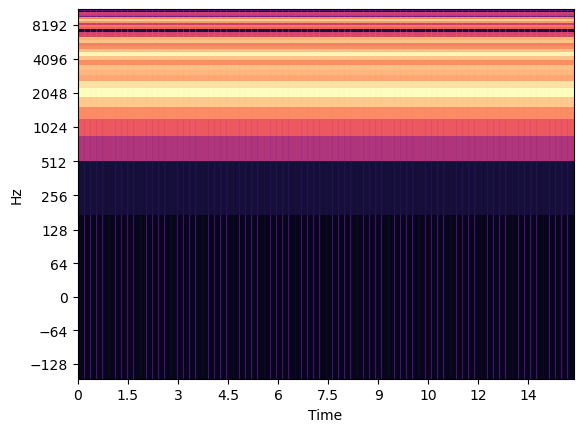

In [27]:
librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(stft[0]), ref=np.max),
    y_axis='log', x_axis='time'
)

In [28]:
test_y = Y.cpu().numpy()
y_mag = test_y[:, :, 0, :]
y_angle = test_y[:, :, 1, :] * np.pi
y_stft = (y_mag * np.exp(1j * y_angle)).transpose(1, 2, 0)
y_data = librosa.istft(y_stft[0], n_fft=256, win_length=256, hop_length=256, center=False)

Audio(data=y_data, rate=rate)

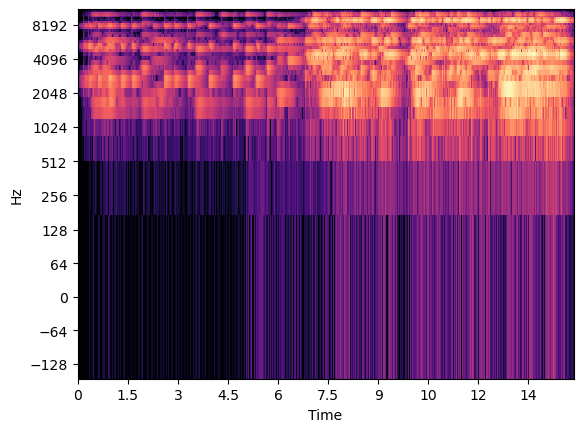

In [29]:
librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(y_stft[0]), ref=np.max),
    y_axis='log', x_axis='time'
)

### WAV

In [26]:
y_true = Y.cpu().numpy().transpose(1, 0, 2).reshape(11, -1)

In [27]:
conv_rate = 1e4

In [28]:
np.abs(y_true[idx]-wav[idx]).mean()

0.62538046

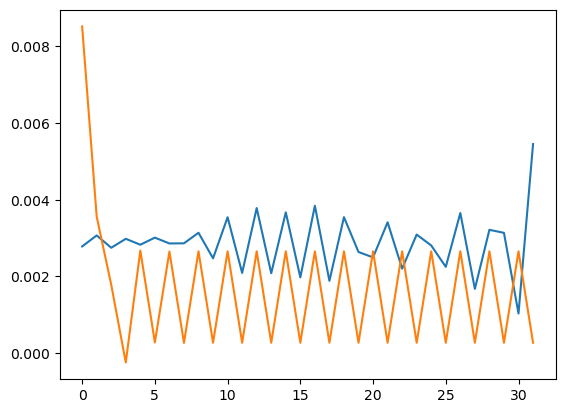

In [29]:
bidx = 0
plt.plot(y_true[0, bidx*minibatch_size:(bidx+1)*minibatch_size])
plt.plot(wav[0, bidx*minibatch_size:(bidx+1)*minibatch_size])

Y-True


Predict


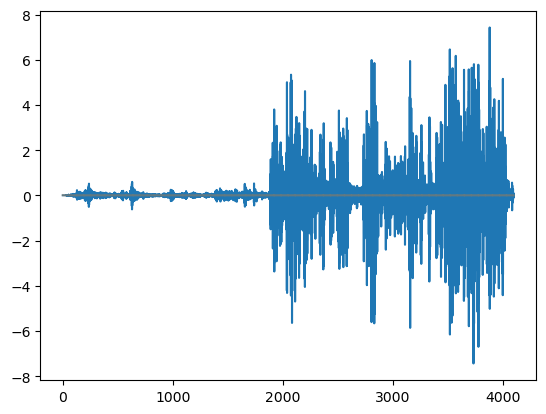

In [30]:
idx = 0
plt.plot(y_true[idx])
plt.plot(wav[idx], alpha=0.3)
print('Y-True')
display(Audio(data=librosa.resample(y_true[idx], orig_sr=target_sr, target_sr=conv_rate), rate=conv_rate))
print('Predict')
display(Audio(data=librosa.resample(wav[idx], orig_sr=target_sr, target_sr=conv_rate), rate=conv_rate))

## Test

In [30]:
prep_Y_mag = np.abs(raw_Y)
prep_Y_phase = np.angle(raw_Y)
rev_Y_stft = (prep_Y_mag * np.exp(1j * prep_Y_phase))

raw_stft = rev_Y_stft[:, :, 0, :].transpose(0, 2, 1)
raw_data = librosa.istft(raw_stft[0], n_fft=256, win_length=256, hop_length=256, center=False)

Audio(data=raw_data, rate=rate)